In [1]:
import pyxdf
import mne
import numpy as np
streams, header = pyxdf.load_xdf("sub-P005/ses-S001/eeg/sub-P005_ses-S001_task-Default_run-001_eeg.xdf") #Example Data from Lab Recoder

Stream 1: Calculated effective sampling rate 184.9737 Hz is different from specified rate 250.0000 Hz.


In [2]:
streams

[{'info': defaultdict(list,
              {'name': ['obci_eeg1'],
               'type': ['EEG'],
               'channel_count': ['8'],
               'nominal_srate': ['250'],
               'channel_format': ['float32'],
               'source_id': ['openbcigui'],
               'version': ['1.1000000000000001'],
               'created_at': ['50625.090058278001'],
               'uid': ['0c9963df-1bea-4888-9b52-bd045eb5b77f'],
               'session_id': ['default'],
               'hostname': ['MRPrayads-MacBook-Pro.local'],
               'v4address': [None],
               'v4data_port': ['16572'],
               'v4service_port': ['16572'],
               'v6address': [None],
               'v6data_port': ['0'],
               'v6service_port': ['0'],
               'desc': [None],
               'stream_id': 1,
               'effective_srate': 184.97367295059448}),
  'footer': {'info': defaultdict(list,
               {'first_timestamp': ['52747.81840181'],
                '

In [3]:
raw_data = streams[0]["time_series"].T #From Steam variable this query is EEG data

In [4]:
raw_data.shape

(8, 48510)

In [5]:
channels = ['CH1','CH2','CH3','CH4','CH5','CH6','CH7','CH8'] #Set your target EEG channel name
info = mne.create_info(
    ch_names= channels,
    ch_types= ['eeg']*len(channels),
    sfreq= 250 #OpenBCI Frequency acquistion
)
# Create MNE rawarray
raw_mne = mne.io.RawArray(raw_data, info, verbose=False)

In [6]:
raw_mne

Measurement date,Unknown
Experimenter,Unknown
Participant,Unknown
Digitized points,Not available
Good channels,8 EEG
Bad channels,None
EOG channels,Not available
ECG channels,Not available
Sampling frequency,250.00 Hz
Highpass,0.00 Hz
Lowpass,125.00 Hz


In [7]:
raw_mne_dropped = raw_mne.drop_channels(ch_names=['CH1','CH2','CH3','CH4'],on_missing='raise')

In [8]:
raw_mne_dropped

Measurement date,Unknown
Experimenter,Unknown
Participant,Unknown
Digitized points,Not available
Good channels,4 EEG
Bad channels,None
EOG channels,Not available
ECG channels,Not available
Sampling frequency,250.00 Hz
Highpass,0.00 Hz
Lowpass,125.00 Hz


In [52]:
event_index = streams[1]["time_series"].T[0] #Get all event marker of experiment 
event_timestamp = streams[1]["time_stamps"].T #Timestamp when event marked

In [53]:
event_index

array([0, 1, 2, 3, 4, 0, 1, 2, 3, 4, 0, 1, 2, 3, 4])

In [54]:
streams[1]["time_stamps"][0]

2249108.8799363854

In [55]:
event_timestamp = [0]
for i in range(1,len(streams[1]["time_series"])):
    event_timestamp.append( int(streams[1]["time_stamps"][i])-int(streams[1]["time_stamps"][0]))
event_timestamp
event_timestamp = np.array(event_timestamp)
event_timestamp = event_timestamp.T
print(type(event_timestamp))

<class 'numpy.ndarray'>


In [56]:
events = np.column_stack((np.array(event_timestamp, dtype = int),
                        np.zeros(len(event_timestamp), dtype = int),
                        np.array(event_index, dtype = int)))

In [57]:
raw_mne_dropped[0]

(array([[-19073.5703125 , -16517.29101562, -14282.07226562, ...,
         -12297.97460938, -12266.97265625, -12308.92675781]]),
 array([0.00000e+00, 4.00000e-03, 8.00000e-03, ..., 1.94028e+02,
        1.94032e+02, 1.94036e+02]))

In [68]:
events

array([[  0,   0,   0],
       [ 10,   0,   1],
       [ 30,   0,   2],
       [ 50,   0,   3],
       [ 70,   0,   4],
       [ 90,   0,   0],
       [100,   0,   1],
       [120,   0,   2],
       [140,   0,   3],
       [160,   0,   4],
       [180,   0,   0],
       [190,   0,   1],
       [210,   0,   2],
       [230,   0,   3],
       [250,   0,   4]])

In [74]:


events_id = { # Set up your event name
     'break': 0,
     'forward': 1,
     'left': 2,
     'right': 3,
     'backward': 4,
     
}


mne_epochs = mne.Epochs(raw_mne_dropped, events, 
        tmin= 0.0,     # init timestamp of epoch (0 means trigger timestamp same as event start)
        tmax= 20.0,    # final timestamp (10 means set epoch duration 10 second)
        event_id =events_id,
     #    reject= dict(eeg = 40e-6),
     #    flat= dict(eeg = 1e-6),
        preload = True,
        baseline = (0.0,0.5)
        
    )



Not setting metadata
15 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 15 events and 5001 original time points ...
0 bad epochs dropped


In [80]:
mne_epochs

Number of events,15
Events,backward: 3break: 3forward: 3left: 3right: 3
Time range,0.000 – 20.000 s
Baseline,0.000 – 0.500 s


In [76]:
dropped_log = mne_epochs.plot_drop_log

In [77]:
dropped_log

<bound method BaseEpochs.plot_drop_log of <Epochs |  15 events (all good), 0 – 20 s, baseline 0 – 0.5 s, ~2.3 MB, data loaded,
 'break': 3
 'forward': 3
 'left': 3
 'right': 3
 'backward': 3>>

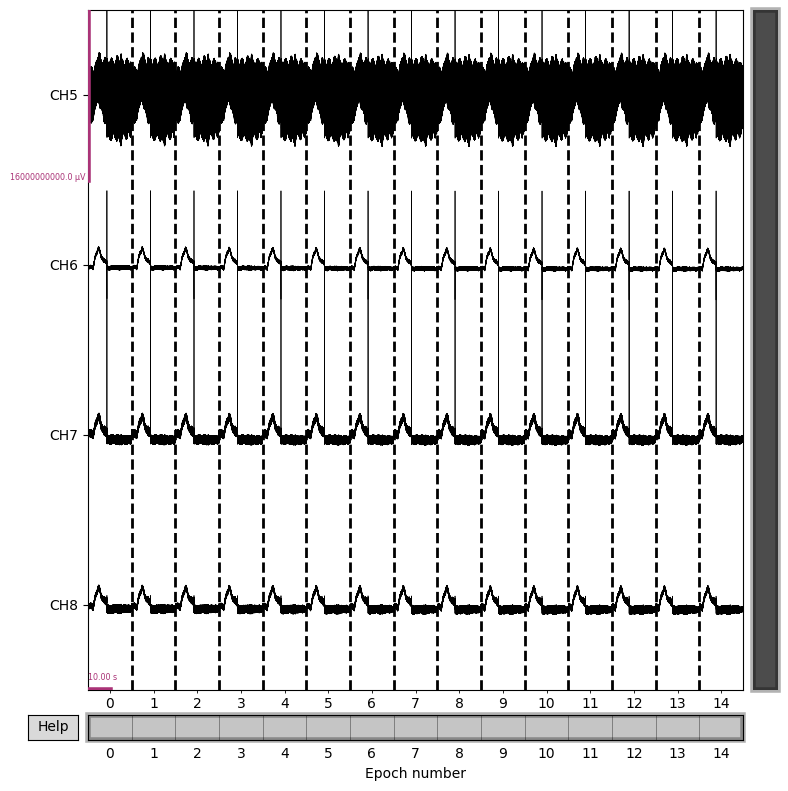

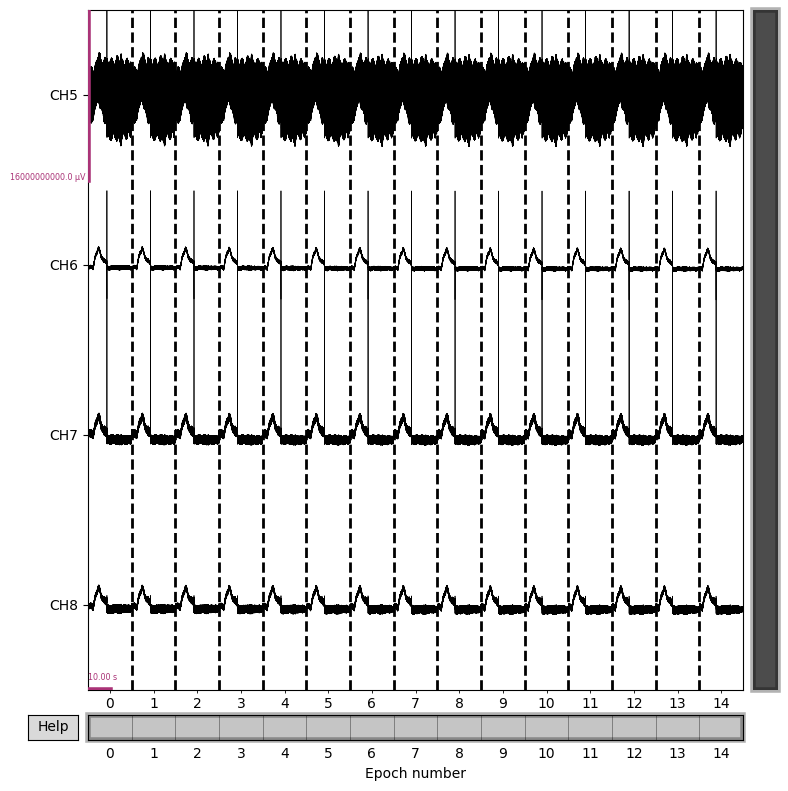

In [83]:
mne_epochs.plot(scalings = 8000)
